# 1- CNN- Rate Coding   

C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_1840\2647115322.py:54: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('jordan_pv.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_1840\2647115322.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset = read_csv('jordan_pv.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')


   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.144796   0.453172        1.0   0.747222   0.044444        0.0   
4   0.144796   0.453172        1.0   0.625000   0.044444        0.0   
5   0.140271   0.447130        1.0   0.436111   0.044444        0.0   
6   0.135747   0.441088        1.0   0.322222   0.077778        0.0   
7   0.147059   0.456193        1.0   0.300000   0.133333        0.0   

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
3   0.144796   0.453172   1.000000   0.625000   0.044444   0.000000   
4   0.140271   0.447130   1.000000   0.436111   0.044444   0.000000   
5   0.135747   0.441088   1.000000   0.322222   0.077778   0.000000   
6   0.147059   0.456193   1.000000   0.300000   0.133333   0.000000   
7   0.180995   0.492447   0.980555   0.291667   0.233333   0.110497   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
3   0.140271   0.447130   1.000000   0.436111   0.044444   0.000000   
4   

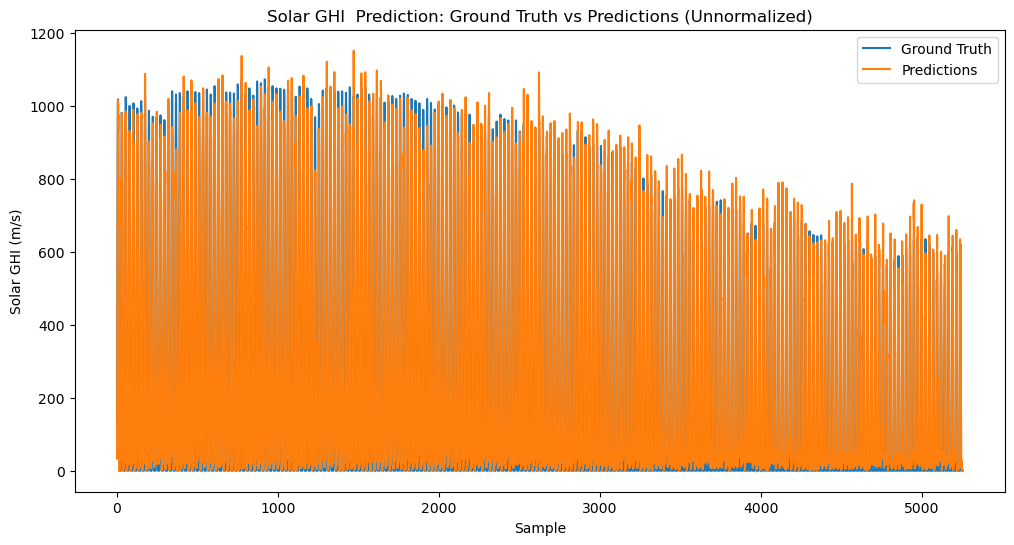

In [15]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# ===========================
# 1. Data Preparation
# ===========================

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    # (Same as your original function)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars - 1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Load data
dataset = read_csv('jordan_pv.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
#dataset = read_csv('Palestine-PV.csv', parse_dates=['date'],index_col='date')

dataset.index.name = 'Date'
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

dataset = dataset.sort_values('Date', ascending=True)
# Convert all columns to float64
dataset = dataset.astype('float64')

# Drop rows with missing values
dataset = dataset.dropna()

# Scale features
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)

# Save target scaling parameters
target_min = scaler.data_min_[-1]
target_max = scaler.data_max_[-1]

# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', n_in=3, n_out=1)
print(reframed.head())

# Split into Train and Test Set
values = reframed.values
n_train_hours = 876 * 24  # Adjust based on your dataset size
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# ===========================
# 2. Rate Encoding and Decoding Functions
# ===========================

def rate_encoding(batch, time_steps):
    """
    Rate Encoding: Converts continuous input values into spike trains based on spike probability.
    """
    # Calculate spike probability
    spike_prob = batch.unsqueeze(2)  # Shape: [batch_size, num_features, 1]

    # Generate spike trains
    spike_trains = torch.rand(batch.shape[0], batch.shape[1], time_steps, device=batch.device) < spike_prob

    return spike_trains.float()  # Shape: [batch_size, num_features, time_steps]

def rate_decoding(spike_trains, time_steps):
    """
    Rate Decoding: Convert spike-encoded data back to continuous values.
    """
    # Sum over time steps
    spike_counts = spike_trains.sum(dim=2)  # Shape: [batch_size, out_channels, height, width]

    # Remove height and width dimensions if they are 1
    if spike_counts.dim() == 4:
        spike_counts = spike_counts.squeeze(-1).squeeze(-1)  # Shape: [batch_size, out_channels]

    # Average over time steps
    decoded_output = spike_counts / time_steps  # Shape: [batch_size, out_channels]

    # If out_channels is 1, squeeze the dimension
    if decoded_output.shape[1] == 1:
        decoded_output = decoded_output.squeeze(1)  # Shape: [batch_size]

    return decoded_output

# ===========================
# 3. Data Conversion and Encoding
# ===========================

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [samples, 1]
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [samples, 1]

# Encode the inputs using Rate encoding
time_steps = 100  # Number of time steps
train_X_encoded = rate_encoding(train_X, time_steps)
test_X_encoded = rate_encoding(test_X, time_steps)

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.1),
        }
        self.blocks = torch.nn.ModuleList([
            slayer.block.sigma_delta.Conv(sdnn_params, 18, 32, kernel_size=1),
            slayer.block.sigma_delta.Conv(sdnn_params, 32, 32, kernel_size=1),
            #slayer.block.sigma_delta.Flatten(),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x  # Output shape: [batch_size, out_channels, time_steps, 1, 1]

# ===========================
# 5. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

# ===========================
# 6. Creating DataLoaders
# ===========================

class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 7. Training Loop with Scheduler (Early Stopping Removed)
# ===========================

num_epochs = 60
best_val_loss = float('inf')

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input, ground_truth in train_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        # Reshape input to [batch_size, channels, time_steps, height, width]
        input = input.unsqueeze(3).unsqueeze(4)  # Shape: [batch_size, channels, time_steps, 1, 1]

        optimizer.zero_grad()
        output = net(input)  # Output shape: [batch_size, out_channels, time_steps, 1, 1]
        decoded_output = rate_decoding(output, time_steps)  # Shape: [batch_size]
        ground_truth = ground_truth.view(-1)                # Shape: [batch_size]
        loss = criterion(decoded_output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')

    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input, ground_truth in test_loader:
            input, ground_truth = input.to(device), ground_truth.to(device)
            input = input.unsqueeze(3).unsqueeze(4)
            output = net(input)
            decoded_output = rate_decoding(output, time_steps)
            ground_truth = ground_truth.view(-1)
            loss = criterion(decoded_output, ground_truth)
            val_loss += loss.item() * input.size(0)
    val_loss /= len(test_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(net.state_dict(), 'RCbest_model.pth')

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('RCbest_model.pth'))

# ===========================
# 8. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input, ground_truth in test_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        input = input.unsqueeze(3).unsqueeze(4)
        output = net(input)
        decoded_output = rate_decoding(output, time_steps)
        ground_truth = ground_truth.view(-1)
        test_predictions.append(decoded_output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, and MAE
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI (m/s)')
plt.title('Solar GHI  Prediction: Ground Truth vs Predictions (Unnormalized)')
plt.show()


# 2- MLP - Rate Coding   

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.183879   0.415335   0.813153   0.544444   0.075472        0.0   
4   0.176322   0.415335   0.828331   0.144444   0.075472        0.0   
5   0.171285   0.412141   0.835526   0.213889   0.094340        0.0   
6   0.166247   0.412141   0.850028   0.250000   0.113208        0.0   
7   0.173804   0.415335   0.835975   0.275000   0.169811        0.0   

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
3   0.176322   0.415335   0.828331   0.144444   0.075472    0.00000   
4   0.171285   0.412141   0.835526   0.213889   0.094340    0.00000   
5   0.166247   0.412141   0.850028   0.250000   0.113208    0.00000   
6   0.173804   0.415335   0.835975   0.275000   0.169811    0.00000   
7   0.201511   0.434505   0.805059   0.286111   0.226415    0.09981   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
3   0.171285   0.412141   0.835526   0.213889   0.094340    0.00000   
4   

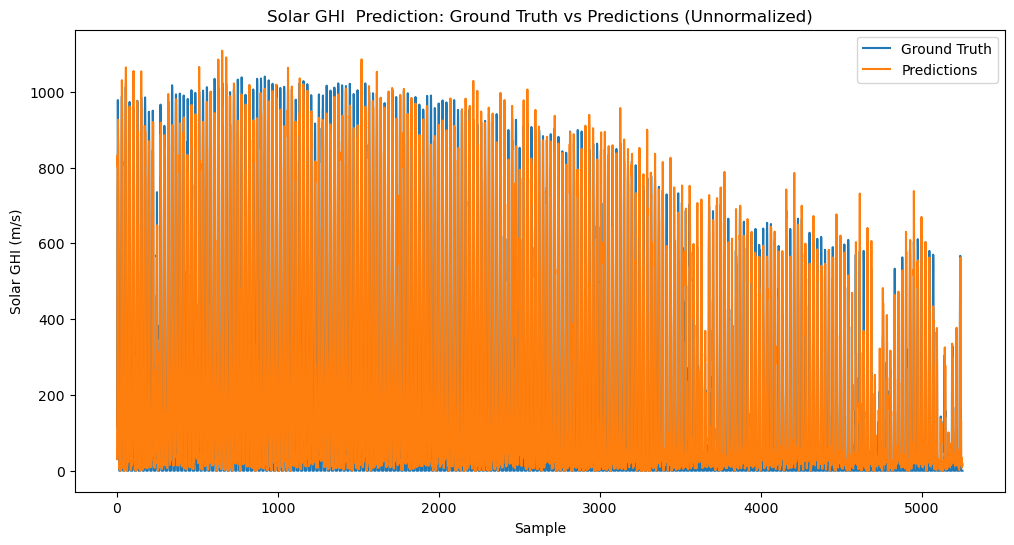

In [19]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# ===========================
# 1. Data Preparation
# ===========================
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    # (Same as your original function)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars - 1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Load data
#dataset = read_csv('jordan_pv.csv', parse_dates=['date'],  index_col='date')
dataset = read_csv('Palestine-PV.csv', parse_dates=['date'],index_col='date')

dataset.index.name = 'Date'
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

dataset = dataset.sort_values('Date', ascending=True)
# Convert all columns to float64
dataset = dataset.astype('float64')

# Drop rows with missing values
dataset = dataset.dropna()

# Scale features
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)

# Save target scaling parameters
target_min = scaler.data_min_[-1]
target_max = scaler.data_max_[-1]

# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', n_in=3, n_out=1)
print(reframed.head())

# Split into Train and Test Set
values = reframed.values
n_train_hours = 876 * 24  # Adjust based on your dataset size
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# ===========================
# 2. Rate Encoding and Decoding Functions
# ===========================

def rate_encoding(batch, time_steps):
    """
    Rate Encoding: Converts continuous input values into spike trains based on spike probability.
    """
    # Calculate spike probability
    spike_prob = batch.unsqueeze(2)  # Shape: [batch_size, num_features, 1]

    # Generate spike trains
    spike_trains = torch.rand(batch.shape[0], batch.shape[1], time_steps, device=batch.device) < spike_prob

    return spike_trains.float()  # Shape: [batch_size, num_features, time_steps]

def rate_decoding(spike_trains, time_steps):
    """
    Rate Decoding: Convert spike-encoded data back to continuous values.
    """
    # Sum over time steps
    spike_counts = spike_trains.sum(dim=2)  # Shape: [batch_size, out_channels, height, width]

    # Remove height and width dimensions if they are 1
    if spike_counts.dim() == 4:
        spike_counts = spike_counts.squeeze(-1).squeeze(-1)  # Shape: [batch_size, out_channels]

    # Average over time steps
    decoded_output = spike_counts / time_steps  # Shape: [batch_size, out_channels]

    # If out_channels is 1, squeeze the dimension
    if decoded_output.shape[1] == 1:
        decoded_output = decoded_output.squeeze(1)  # Shape: [batch_size]

    return decoded_output

# ===========================
# 3. Data Conversion and Encoding
# ===========================

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [samples, 1]
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [samples, 1]

# Encode the inputs using Rate encoding
time_steps = 100  # Number of time steps
train_X_encoded = rate_encoding(train_X, time_steps)
test_X_encoded = rate_encoding(test_X, time_steps)

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.1),
        }
        self.blocks = torch.nn.ModuleList([

            slayer.block.sigma_delta.Dense(sdnn_dense_params, 18, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x  # Output shape: [batch_size, out_channels, time_steps, 1, 1]

# ===========================
# 5. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

# ===========================
# 6. Creating DataLoaders
# ===========================

class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 7. Training Loop with Scheduler (Early Stopping Removed)
# ===========================

num_epochs = 60
best_val_loss = float('inf')

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input, ground_truth in train_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        # Reshape input to [batch_size, channels, time_steps, height, width]
        input = input.unsqueeze(3).unsqueeze(4)  # Shape: [batch_size, channels, time_steps, 1, 1]

        optimizer.zero_grad()
        output = net(input)  # Output shape: [batch_size, out_channels, time_steps, 1, 1]
        decoded_output = rate_decoding(output, time_steps)  # Shape: [batch_size]
        ground_truth = ground_truth.view(-1)                # Shape: [batch_size]
        loss = criterion(decoded_output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')

    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input, ground_truth in test_loader:
            input, ground_truth = input.to(device), ground_truth.to(device)
            input = input.unsqueeze(3).unsqueeze(4)
            output = net(input)
            decoded_output = rate_decoding(output, time_steps)
            ground_truth = ground_truth.view(-1)
            loss = criterion(decoded_output, ground_truth)
            val_loss += loss.item() * input.size(0)
    val_loss /= len(test_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(net.state_dict(), 'RCbest_model.pth')

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('RCbest_model.pth'))

# ===========================
# 8. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input, ground_truth in test_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        input = input.unsqueeze(3).unsqueeze(4)
        output = net(input)
        decoded_output = rate_decoding(output, time_steps)
        ground_truth = ground_truth.view(-1)
        test_predictions.append(decoded_output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, and MAE
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI (m/s)')
plt.title('Solar GHI  Prediction: Ground Truth vs Predictions (Unnormalized)')
plt.show()


# 3-CNN -  TTFS Coding  

C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_1840\1688881088.py:54: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('Palestine-PV.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')


   Air Temperature(t-3)  Dew Point(t-3)  Relative Humidity(t-3)  \
3              0.183879        0.415335                0.813153   
4              0.176322        0.415335                0.828331   
5              0.171285        0.412141                0.835526   
6              0.166247        0.412141                0.850028   
7              0.173804        0.415335                0.835975   

   Wind Direction(t-3)  Wind Speed(t-3)  Solar Radiation(GHI)(t-3)  \
3             0.544444         0.075472                        0.0   
4             0.144444         0.075472                        0.0   
5             0.213889         0.094340                        0.0   
6             0.250000         0.113208                        0.0   
7             0.275000         0.169811                        0.0   

   Air Temperature(t-2)  Dew Point(t-2)  Relative Humidity(t-2)  \
3              0.176322        0.415335                0.828331   
4              0.171285        0.412141   

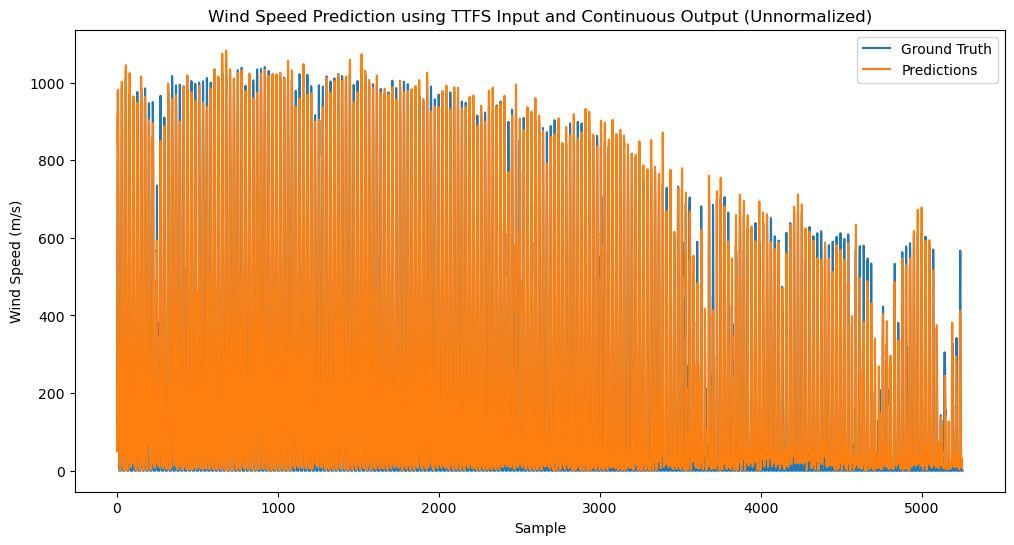

In [21]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn

# ===========================
# 1. Data Preparation
# ===========================

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{col}(t-{i})' for col in df.columns]

    # Forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{col}(t)' for col in df.columns]
        else:
            names += [f'{col}(t+{i})' for col in df.columns]

    # Concatenate all columns
    agg = concat(cols, axis=1)
    agg.columns = names

    # Keep only the necessary columns
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Load data
#dataset = read_csv('jordan_pv.csv', parse_dates=['date'],  index_col='date')
dataset = read_csv('Palestine-PV.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')

#dataset = read_csv('AAUP_Wind_Avg_Hourly.csv', parse_dates=['Date'], index_col=0, encoding='ISO-8859-1')
#dataset.columns = ['Air_temperature_Avg_°C', 'Relative_humidity_Avg%', 'Wind_direction_last_deg', 'Air_pressure_kPa', 'Wind_speed_avg_m/s']
dataset.index.name = 'Date'
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

dataset = dataset.sort_values('Date', ascending=True)

# Convert all columns to float64
dataset = dataset.astype('float64')

# Drop rows with missing values
dataset = dataset.dropna()

# Scale features
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)

# Save target scaling parameters
target_min = scaler.data_min_[-1]
target_max = scaler.data_max_[-1]

# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', n_in=3, n_out=1)
print(reframed.head())

# Split into Train and Test Set
values = reframed.values
n_train_hours = 876 * 24  # Adjust based on your dataset size
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into inputs and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# ===========================
# 2. Data Conversion and Encoding
# ===========================

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)  # Shape: [samples]
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)    # Shape: [samples]

# Encode the inputs using TTFS encoding
time_steps = 100  # Number of time steps

def ttfs_encoding(batch, max_time_steps):
    """
    TTFS Encoding without epsilon adjustment.
    """
    spike_times = (1.0 - batch) * (max_time_steps - 1)
    spike_times = spike_times.long()
    return spike_times


# Generate input spike times
train_spike_times = ttfs_encoding(train_X, time_steps)
test_spike_times = ttfs_encoding(test_X, time_steps)

def generate_ttfs_spike_trains(spike_times, max_time_steps):
    """
    Generate spike trains with spikes from time 0 up to the spike time.
    """
    batch_size, num_features = spike_times.shape
    spike_trains = torch.zeros(batch_size, num_features, max_time_steps, device=spike_times.device)
    for b in range(batch_size):
        for n in range(num_features):
            t = spike_times[b, n]
            spike_trains[b, n, :t+1] = 1.0  # Spikes from time 0 to t
    return spike_trains  # Shape: [batch_size, num_features, time_steps]


train_X_encoded = generate_ttfs_spike_trains(train_spike_times, time_steps)
test_X_encoded = generate_ttfs_spike_trains(test_spike_times, time_steps)

# Reshape to match SLAYER's expected input shape
# [batch_size, channels, time_steps, height, width]
train_X_encoded = train_X_encoded.unsqueeze(3).unsqueeze(4)  # Shape: [batch_size, num_features, time_steps, 1, 1]
test_X_encoded = test_X_encoded.unsqueeze(3).unsqueeze(4)

# ===========================
# 3. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.1),
        }
        self.blocks = torch.nn.ModuleList([
            slayer.block.sigma_delta.Conv(sdnn_params, 18, 32, kernel_size=1),
            slayer.block.sigma_delta.Conv(sdnn_params, 32, 32, kernel_size=1),
            #slayer.block.sigma_delta.Flatten(),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = x.squeeze(-1).squeeze(-1)  # Shape: [batch_size, channels, time_steps]
        x = x.mean(dim=2)  # Average over time steps, shape: [batch_size, channels]
        x = x.squeeze(1)  # Shape: [batch_size]
        return x  # Shape: [batch_size]


# 4. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# ===========================
# 5. Creating DataLoaders
# ===========================

class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

num_epochs = 60
best_val_loss = float('inf')
patience = 20
trigger_times = 0

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input, ground_truth in train_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        optimizer.zero_grad()
        output = net(input)  # Output shape: [batch_size]
        loss = criterion(output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')
    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input, ground_truth in test_loader:
            input, ground_truth = input.to(device), ground_truth.to(device)
            output = net(input)
            loss = criterion(output, ground_truth)
            val_loss += loss.item() * input.size(0)
    val_loss /= len(test_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    # Scheduler step
    scheduler.step(val_loss)
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # Save the best model
        torch.save(net.state_dict(), 'TTFS_best_model.pth')
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}')
        if trigger_times >= patience:
            print('Early stopping!')
            break

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
# Calculate and print the minimum validation RMSE
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('TTFS_best_model.pth'))

# ===========================
# 7. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input, ground_truth in test_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        output = net(input)
        test_predictions.append(output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, and MAE
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Prediction using TTFS Input and Continuous Output (Unnormalized)')
plt.show()


# 4- MLP -TTFS

C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_1840\1442098830.py:54: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('Palestine-PV.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')


   Air Temperature(t-3)  Dew Point(t-3)  Relative Humidity(t-3)  \
3              0.183879        0.415335                0.813153   
4              0.176322        0.415335                0.828331   
5              0.171285        0.412141                0.835526   
6              0.166247        0.412141                0.850028   
7              0.173804        0.415335                0.835975   

   Wind Direction(t-3)  Wind Speed(t-3)  Solar Radiation(GHI)(t-3)  \
3             0.544444         0.075472                        0.0   
4             0.144444         0.075472                        0.0   
5             0.213889         0.094340                        0.0   
6             0.250000         0.113208                        0.0   
7             0.275000         0.169811                        0.0   

   Air Temperature(t-2)  Dew Point(t-2)  Relative Humidity(t-2)  \
3              0.176322        0.415335                0.828331   
4              0.171285        0.412141   

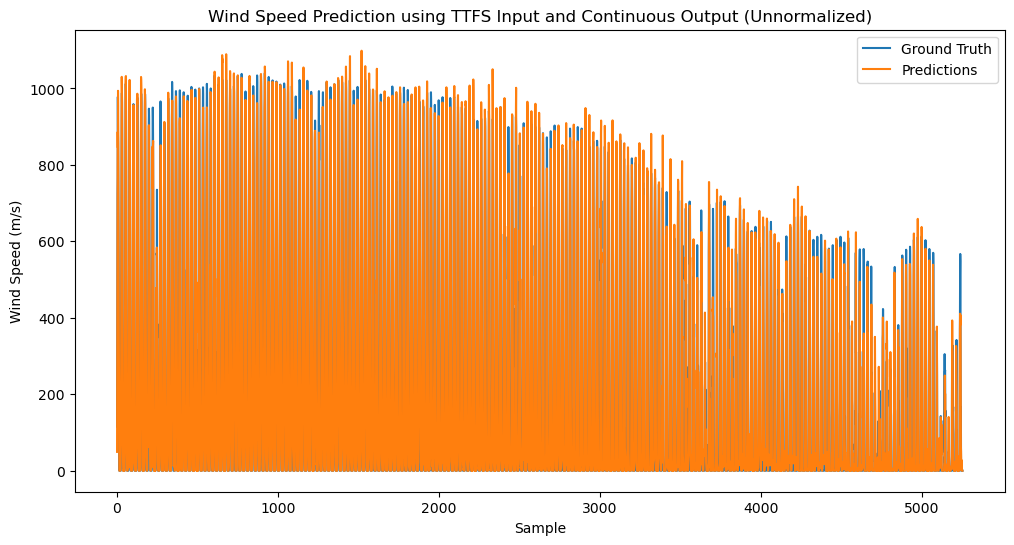

In [23]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn

# ===========================
# 1. Data Preparation
# ===========================

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{col}(t-{i})' for col in df.columns]

    # Forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{col}(t)' for col in df.columns]
        else:
            names += [f'{col}(t+{i})' for col in df.columns]

    # Concatenate all columns
    agg = concat(cols, axis=1)
    agg.columns = names

    # Keep only the necessary columns
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Load data
#dataset = read_csv('jordan_pv.csv', parse_dates=['date'],  index_col='date')
dataset = read_csv('Palestine-PV.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')

#dataset = read_csv('AAUP_Wind_Avg_Hourly.csv', parse_dates=['Date'], index_col=0, encoding='ISO-8859-1')
#dataset.columns = ['Air_temperature_Avg_°C', 'Relative_humidity_Avg%', 'Wind_direction_last_deg', 'Air_pressure_kPa', 'Wind_speed_avg_m/s']
dataset.index.name = 'Date'
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

dataset = dataset.sort_values('Date', ascending=True)

# Convert all columns to float64
dataset = dataset.astype('float64')

# Drop rows with missing values
dataset = dataset.dropna()

# Scale features
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)

# Save target scaling parameters
target_min = scaler.data_min_[-1]
target_max = scaler.data_max_[-1]

# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', n_in=3, n_out=1)
print(reframed.head())

# Split into Train and Test Set
values = reframed.values
n_train_hours = 876 * 24  # Adjust based on your dataset size
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into inputs and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# ===========================
# 2. Data Conversion and Encoding
# ===========================

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)  # Shape: [samples]
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)    # Shape: [samples]

# Encode the inputs using TTFS encoding
time_steps = 100  # Number of time steps

def ttfs_encoding(batch, max_time_steps):
    """
    TTFS Encoding without epsilon adjustment.
    """
    spike_times = (1.0 - batch) * (max_time_steps - 1)
    spike_times = spike_times.long()
    return spike_times


# Generate input spike times
train_spike_times = ttfs_encoding(train_X, time_steps)
test_spike_times = ttfs_encoding(test_X, time_steps)

def generate_ttfs_spike_trains(spike_times, max_time_steps):
    """
    Generate spike trains with spikes from time 0 up to the spike time.
    """
    batch_size, num_features = spike_times.shape
    spike_trains = torch.zeros(batch_size, num_features, max_time_steps, device=spike_times.device)
    for b in range(batch_size):
        for n in range(num_features):
            t = spike_times[b, n]
            spike_trains[b, n, :t+1] = 1.0  # Spikes from time 0 to t
    return spike_trains  # Shape: [batch_size, num_features, time_steps]


train_X_encoded = generate_ttfs_spike_trains(train_spike_times, time_steps)
test_X_encoded = generate_ttfs_spike_trains(test_spike_times, time_steps)

# Reshape to match SLAYER's expected input shape
# [batch_size, channels, time_steps, height, width]
train_X_encoded = train_X_encoded.unsqueeze(3).unsqueeze(4)  # Shape: [batch_size, num_features, time_steps, 1, 1]
test_X_encoded = test_X_encoded.unsqueeze(3).unsqueeze(4)

# ===========================
# 3. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.1),
        }
        self.blocks = torch.nn.ModuleList([

            slayer.block.sigma_delta.Dense(sdnn_dense_params, 18, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = x.squeeze(-1).squeeze(-1)  # Shape: [batch_size, channels, time_steps]
        x = x.mean(dim=2)  # Average over time steps, shape: [batch_size, channels]
        x = x.squeeze(1)  # Shape: [batch_size]
        return x  # Shape: [batch_size]


# 4. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# ===========================
# 5. Creating DataLoaders
# ===========================

class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

num_epochs = 60
best_val_loss = float('inf')
patience = 20
trigger_times = 0

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input, ground_truth in train_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        optimizer.zero_grad()
        output = net(input)  # Output shape: [batch_size]
        loss = criterion(output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')
    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input, ground_truth in test_loader:
            input, ground_truth = input.to(device), ground_truth.to(device)
            output = net(input)
            loss = criterion(output, ground_truth)
            val_loss += loss.item() * input.size(0)
    val_loss /= len(test_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    # Scheduler step
    scheduler.step(val_loss)
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # Save the best model
        torch.save(net.state_dict(), 'mlpTTFS_best_model.pth')
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}')
        if trigger_times >= patience:
            print('Early stopping!')
            break

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
# Calculate and print the minimum validation RMSE
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('mlpTTFS_best_model.pth'))

# ===========================
# 7. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input, ground_truth in test_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        output = net(input)
        test_predictions.append(output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, and MAE
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Prediction using TTFS Input and Continuous Output (Unnormalized)')
plt.show()


# 5- CNN - Population

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.183879   0.415335   0.813153   0.544444   0.075472        0.0   
4   0.176322   0.415335   0.828331   0.144444   0.075472        0.0   
5   0.171285   0.412141   0.835526   0.213889   0.094340        0.0   
6   0.166247   0.412141   0.850028   0.250000   0.113208        0.0   
7   0.173804   0.415335   0.835975   0.275000   0.169811        0.0   

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
3   0.176322   0.415335   0.828331   0.144444   0.075472    0.00000   
4   0.171285   0.412141   0.835526   0.213889   0.094340    0.00000   
5   0.166247   0.412141   0.850028   0.250000   0.113208    0.00000   
6   0.173804   0.415335   0.835975   0.275000   0.169811    0.00000   
7   0.201511   0.434505   0.805059   0.286111   0.226415    0.09981   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
3   0.171285   0.412141   0.835526   0.213889   0.094340    0.00000   
4   

D:\Profiles\anaconda\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/60, Training Loss: 0.049717
Epoch 1/60, Validation Loss: 0.010570
Epoch 2/60, Training Loss: 0.013715
Epoch 2/60, Validation Loss: 0.004973
Epoch 3/60, Training Loss: 0.009229
Epoch 3/60, Validation Loss: 0.004211
Epoch 4/60, Training Loss: 0.007366
Epoch 4/60, Validation Loss: 0.003398
Epoch 5/60, Training Loss: 0.006789
Epoch 5/60, Validation Loss: 0.003851
Epoch 6/60, Training Loss: 0.006337
Epoch 6/60, Validation Loss: 0.003577
Epoch 7/60, Training Loss: 0.005907
Epoch 7/60, Validation Loss: 0.003716
Epoch 8/60, Training Loss: 0.005834
Epoch 8/60, Validation Loss: 0.003159
Epoch 9/60, Training Loss: 0.005533
Epoch 9/60, Validation Loss: 0.003187
Epoch 10/60, Training Loss: 0.005352
Epoch 10/60, Validation Loss: 0.003497
Epoch 11/60, Training Loss: 0.005114
Epoch 11/60, Validation Loss: 0.002897
Epoch 12/60, Training Loss: 0.005703
Epoch 12/60, Validation Loss: 0.003280
Epoch 13/60, Training Loss: 0.005062
Epoch 13/60, Validation Loss: 0.002922
Epoch 14/60, Training Loss: 0.

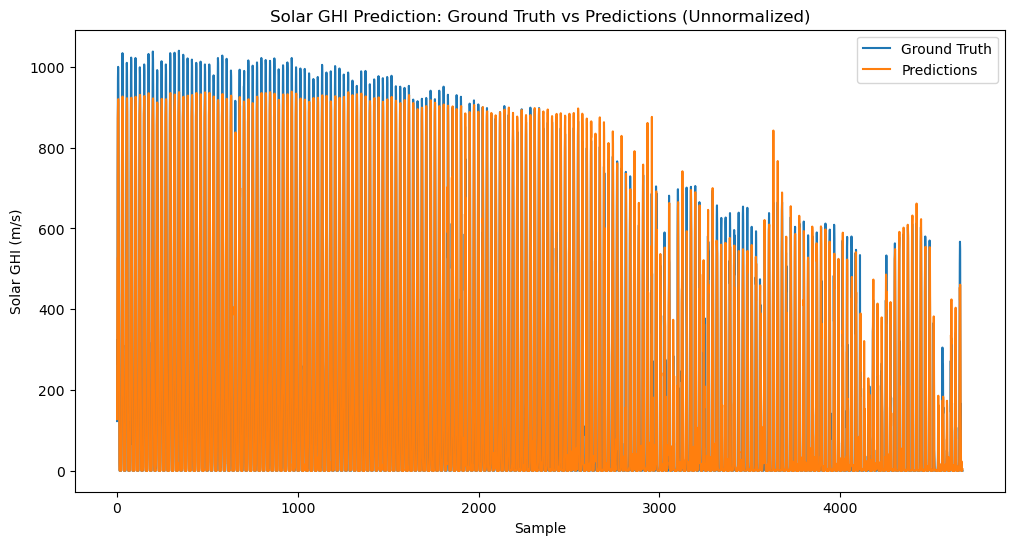

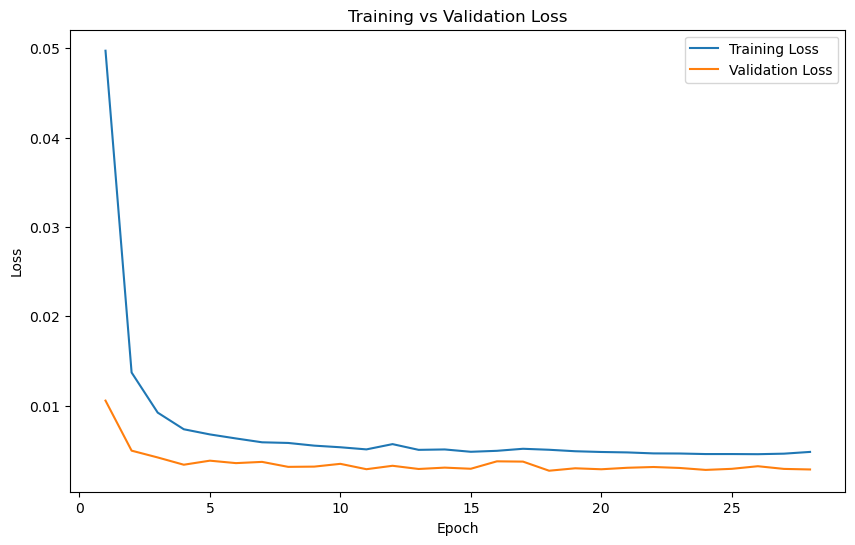

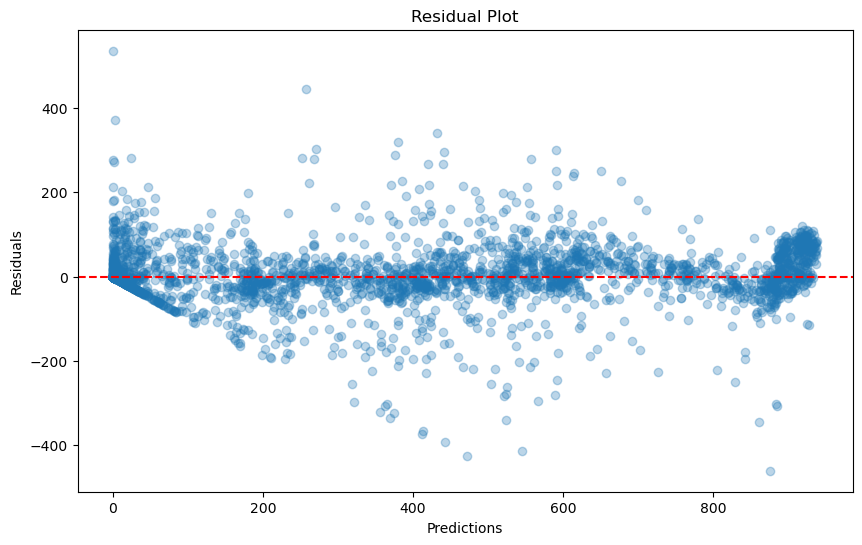

In [76]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# ===========================
# 1. Population Encoding and Decoding Functions
# ===========================

def population_encode(data, num_neurons, min_val, max_val, threshold_prob, time_steps):
    """
    Population Encoding with Temporal Dimension: Converts continuous input values into spike trains over multiple time steps.
    
    Args:
        data (torch.Tensor): Input data tensor of shape [batch_size, num_features].
        num_neurons (int): Number of neurons per input feature.
        min_val (float): Minimum value of the input feature (after scaling).
        max_val (float): Maximum value of the input feature (after scaling).
        threshold_prob (float): Probability scaling factor for spike generation.
        time_steps (int): Number of temporal steps for encoding.
        
    Returns:
        torch.Tensor: Aggregated spike trains of shape [batch_size, num_features, num_neurons].
    """
    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(data.device)  # Shape: [num_neurons]
    sigma = (max_val - min_val) / num_neurons  # Width of the tuning curves

    # Expand dimensions for broadcasting
    data = data.unsqueeze(-1)  # Shape: [batch_size, num_features, 1]
    centers = centers.unsqueeze(0)  # Shape: [1, num_neurons]

    # Calculate Gaussian firing rates
    rates = torch.exp(-(data - centers) ** 2 / (2 * sigma ** 2))  # Shape: [batch_size, num_features, num_neurons]

    # Repeat rates across time_steps
    rates = rates.unsqueeze(0).repeat(time_steps, 1, 1, 1)  # Shape: [time_steps, batch_size, num_features, num_neurons]

    # Generate spikes using Bernoulli sampling
    spikes = torch.bernoulli(rates * threshold_prob)  # Shape: [time_steps, batch_size, num_features, num_neurons]

    # Aggregate spikes over time_steps (e.g., sum)
    spikes_sum = spikes.sum(dim=0)  # Shape: [batch_size, num_features, num_neurons]

    return spikes_sum

def population_decode(spikes, num_neurons, min_val, max_val):
    """
    Population Decoding: Converts spike trains back to continuous values by weighting spikes with their centers.
    
    Args:
        spikes (torch.Tensor): Spike trains of shape [batch_size, num_features, num_neurons].
        num_neurons (int): Number of neurons per input feature.
        min_val (float): Minimum value of the input feature (used during encoding).
        max_val (float): Maximum value of the input feature (used during encoding).
        
    Returns:
        torch.Tensor: Decoded continuous values of shape [batch_size, num_features].
    """
    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(spikes.device)  # Shape: [num_neurons]

    # Decode by weighting the spikes by their receptive field centers and summing
    decoded_values = (spikes * centers).sum(dim=-1)  # Shape: [batch_size, num_features]

    # Normalize by the number of spikes to get the average
    normalization_factor = spikes.sum(dim=-1).clamp(min=1)  # Shape: [batch_size, num_features]
    decoded_values /= normalization_factor  # Shape: [batch_size, num_features]

    return decoded_values

# ===========================
# 2. Data Preparation
# ===========================

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    """
    Converts a time series dataset into a supervised learning format.
    
    Args:
        data (array-like): Sequence of observations as a list or NumPy array.
        target_col_name (str): Name of the target column.
        n_in (int): Number of lag observations as input (X).
        n_out (int): Number of observations as output (y).
        dropnan (bool): Whether to drop rows with NaN values.
        
    Returns:
        DataFrame: Supervised learning formatted DataFrame.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars - 1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Load data
#dataset = read_csv('jordan_pv.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
dataset = read_csv('Palestine-PV.csv', index_col='date')

dataset.index.name = 'Date'
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

dataset = dataset.sort_values('Date', ascending=True)
# Convert all columns to float64
dataset = dataset.astype('float64')

# Drop rows with missing values
dataset = dataset.dropna()

# Scale features
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)

# Save target scaling parameters (Assuming 'Solar Radiation(GHI)' is the last column)
target_min = scaler.data_min_[-1]
target_max = scaler.data_max_[-1]

# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', n_in=3, n_out=1)
print(reframed.head())

# Split into Train and Test Set
values = reframed.values
n_train_hours = 900 * 24  # Adjust based on your dataset size
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # [21024, 18] [21024,] [5253, 18] [5253,]

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)  # Shape: [21024, 18]
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [21024, 1]
test_X = torch.Tensor(test_X)    # Shape: [5253, 18]
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [5253, 1]

# ===========================
# 3. Data Encoding
# ===========================

# Define encoding parameters
num_neurons = 16
threshold_prob = 0.5
min_val = 0.0  # Since data is scaled to [0, 1]
max_val = 1.0  # Since data is scaled to [0, 1]
time_steps = 100  # Increased time_steps to 100

# Population Encode the input features
train_X_encoded = population_encode(train_X, num_neurons, min_val, max_val, threshold_prob, time_steps)  # Shape: [21024, 18, 16]
test_X_encoded = population_encode(test_X, num_neurons, min_val, max_val, threshold_prob, time_steps)    # Shape: [5253, 18, 16]

# Reshape to merge the num_neurons dimension into the channel dimension
# New shape: [batch_size, num_features * num_neurons]
train_X_encoded = train_X_encoded.view(train_X_encoded.size(0), -1)  # Shape: [21024, 288]
test_X_encoded = test_X_encoded.view(test_X_encoded.size(0), -1)     # Shape: [5253, 288]

print(f'Train X Encoded Shape: {train_X_encoded.shape}')  # Expected: [21024, 288]
print(f'Test X Encoded Shape: {test_X_encoded.shape}')    # Expected: [5253, 288]
print(f'Train y Shape: {train_y.shape}')  # [21024, 1]
print(f'Test y Shape: {test_y.shape}')    # [5253, 1]

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, input_channels):
        super(Network, self).__init__()
        self.input_channels = input_channels
        self.output_channels = input_channels  # To maintain the same number of channels for decoding

        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.2),  # Increased dropout for better regularization
        }

        # Simplified network architecture with reduced complexity
        self.blocks = torch.nn.ModuleList([
            slayer.block.sigma_delta.Conv(sdnn_params, self.input_channels, 32, kernel_size=1),  # Reduced channels from 32 to 16
            slayer.block.sigma_delta.Conv(sdnn_params, 32, 32, kernel_size=1),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, self.output_channels),  # Output Channels: 288
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x  # Output shape: [batch_size, 288, 1, 1, 1]

# ===========================
# 5. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the network with correct parameters
input_channels = train_X_encoded.shape[1]  # 288
net = Network(input_channels=input_channels).to(device)

# Optimizer with increased weight decay for stronger regularization
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Mean Squared Error Loss
criterion = torch.nn.MSELoss()

# Learning Rate Scheduler with reduced patience and verbose for better monitoring
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True, threshold=1e-4
)

# ===========================
# 6. Creating DataLoaders
# ===========================

class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 7. Training Loop with Early Stopping
# ===========================

num_epochs = 60
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input_batch, ground_truth in train_loader:
        input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
        # Reshape input to [batch_size, channels, height, width, depth]
        input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, 288, 1, 1, 1]

        optimizer.zero_grad()
        output = net(input_batch)  # Output shape: [batch_size, 288, 1, 1, 1]

        # Remove the last three singleton dimensions
        output = output.view(output.size(0), -1)  # Shape: [batch_size, 288]

        # Reshape back to [batch_size, 18, 16] before decoding
        num_features = 18
        num_neurons = 16
        output = output.view(output.size(0), num_features, num_neurons)  # [batch_size, 18, 16]

        # Decode the output
        decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)  # [batch_size, 18]

        # Extract the target feature (assuming 'Solar Radiation(GHI)' is the last feature)
        decoded_output = decoded_output[:, -1].unsqueeze(1)  # [batch_size, 1]

        loss = criterion(decoded_output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input_batch.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')

    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input_batch, ground_truth in test_loader:
            input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
            input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            output = net(input_batch)
            output = output.view(output.size(0), -1)
            output = output.view(output.size(0), num_features, num_neurons)
            decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)
            decoded_output = decoded_output[:, -1].unsqueeze(1)
            loss = criterion(decoded_output, ground_truth)
            val_loss += loss.item() * input_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), 'cnnpaPEbest_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('cnnpaPEbest_model.pth'))

# ===========================
# 8. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input_batch, ground_truth in test_loader:
        input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
        input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        output = net(input_batch)
        output = output.view(output.size(0), -1)
        output = output.view(output.size(0), num_features, num_neurons)
        decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)
        decoded_output = decoded_output[:, -1].unsqueeze(1)
        test_predictions.append(decoded_output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()  # Shape: [5253, 1]
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()  # Shape: [5253, 1]

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, MAE, and R²
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)
test_r2 = r2_score(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')
print(f'Final Test R² Score: {test_r2:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI (m/s)')
plt.title('Solar GHI Prediction: Ground Truth vs Predictions (Unnormalized)')
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Residual Plot
residuals = test_ground_truth_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(test_predictions_inv, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


# 6- MLP - Population 

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.183879   0.415335   0.813153   0.544444   0.075472        0.0   
4   0.176322   0.415335   0.828331   0.144444   0.075472        0.0   
5   0.171285   0.412141   0.835526   0.213889   0.094340        0.0   
6   0.166247   0.412141   0.850028   0.250000   0.113208        0.0   
7   0.173804   0.415335   0.835975   0.275000   0.169811        0.0   

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
3   0.176322   0.415335   0.828331   0.144444   0.075472    0.00000   
4   0.171285   0.412141   0.835526   0.213889   0.094340    0.00000   
5   0.166247   0.412141   0.850028   0.250000   0.113208    0.00000   
6   0.173804   0.415335   0.835975   0.275000   0.169811    0.00000   
7   0.201511   0.434505   0.805059   0.286111   0.226415    0.09981   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
3   0.171285   0.412141   0.835526   0.213889   0.094340    0.00000   
4   

D:\Profiles\anaconda\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/60, Training Loss: 0.039384
Epoch 1/60, Validation Loss: 0.007536
Epoch 2/60, Training Loss: 0.009658
Epoch 2/60, Validation Loss: 0.004555
Epoch 3/60, Training Loss: 0.007189
Epoch 3/60, Validation Loss: 0.003446
Epoch 4/60, Training Loss: 0.006228
Epoch 4/60, Validation Loss: 0.003131
Epoch 5/60, Training Loss: 0.005689
Epoch 5/60, Validation Loss: 0.003876
Epoch 6/60, Training Loss: 0.005408
Epoch 6/60, Validation Loss: 0.002799
Epoch 7/60, Training Loss: 0.005118
Epoch 7/60, Validation Loss: 0.002834
Epoch 8/60, Training Loss: 0.005141
Epoch 8/60, Validation Loss: 0.002944
Epoch 9/60, Training Loss: 0.004868
Epoch 9/60, Validation Loss: 0.003078
Epoch 10/60, Training Loss: 0.004869
Epoch 10/60, Validation Loss: 0.003043
Epoch 11/60, Training Loss: 0.004762
Epoch 11/60, Validation Loss: 0.003089
Epoch 12/60, Training Loss: 0.004680
Epoch 12/60, Validation Loss: 0.003219
Epoch 13/60, Training Loss: 0.004579
Epoch 13/60, Validation Loss: 0.002744
Epoch 14/60, Training Loss: 0.

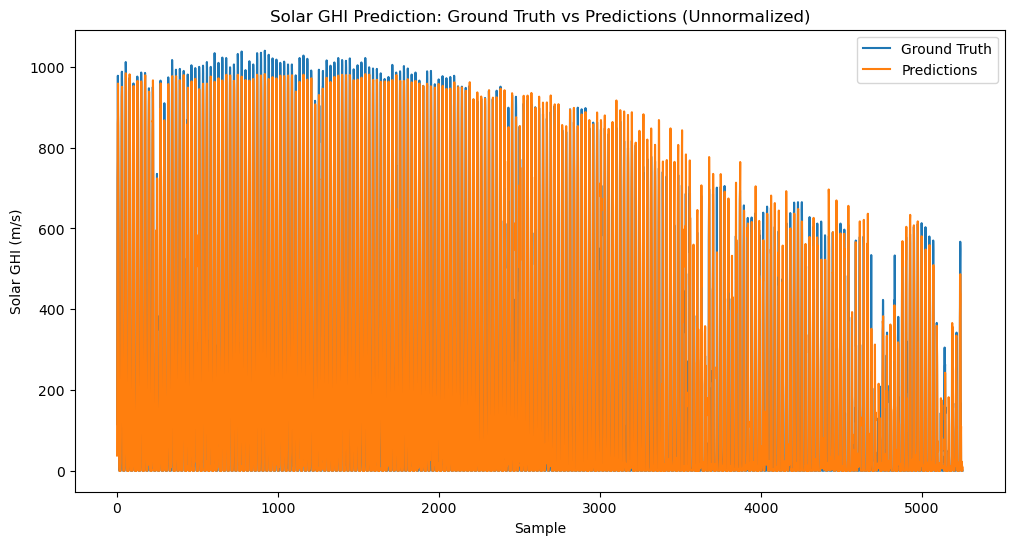

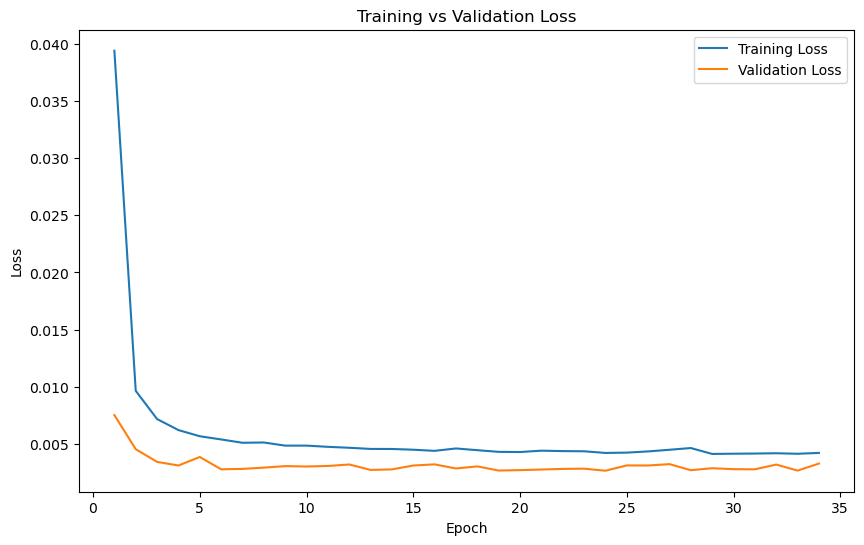

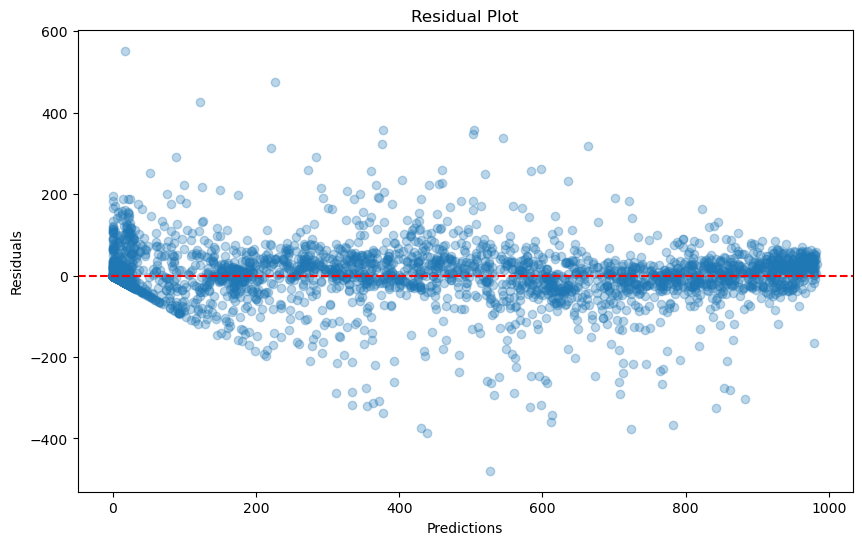

In [74]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# ===========================
# 1. Population Encoding and Decoding Functions
# ===========================

def population_encode(data, num_neurons, min_val, max_val, threshold_prob, time_steps):
    """
    Population Encoding with Temporal Dimension: Converts continuous input values into spike trains over multiple time steps.
    
    Args:
        data (torch.Tensor): Input data tensor of shape [batch_size, num_features].
        num_neurons (int): Number of neurons per input feature.
        min_val (float): Minimum value of the input feature (after scaling).
        max_val (float): Maximum value of the input feature (after scaling).
        threshold_prob (float): Probability scaling factor for spike generation.
        time_steps (int): Number of temporal steps for encoding.
        
    Returns:
        torch.Tensor: Aggregated spike trains of shape [batch_size, num_features, num_neurons].
    """
    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(data.device)  # Shape: [num_neurons]
    sigma = (max_val - min_val) / num_neurons  # Width of the tuning curves

    # Expand dimensions for broadcasting
    data = data.unsqueeze(-1)  # Shape: [batch_size, num_features, 1]
    centers = centers.unsqueeze(0)  # Shape: [1, num_neurons]

    # Calculate Gaussian firing rates
    rates = torch.exp(-(data - centers) ** 2 / (2 * sigma ** 2))  # Shape: [batch_size, num_features, num_neurons]

    # Repeat rates across time_steps
    rates = rates.unsqueeze(0).repeat(time_steps, 1, 1, 1)  # Shape: [time_steps, batch_size, num_features, num_neurons]

    # Generate spikes using Bernoulli sampling
    spikes = torch.bernoulli(rates * threshold_prob)  # Shape: [time_steps, batch_size, num_features, num_neurons]

    # Aggregate spikes over time_steps (e.g., sum)
    spikes_sum = spikes.sum(dim=0)  # Shape: [batch_size, num_features, num_neurons]

    return spikes_sum

def population_decode(spikes, num_neurons, min_val, max_val):
    """
    Population Decoding: Converts spike trains back to continuous values by weighting spikes with their centers.
    
    Args:
        spikes (torch.Tensor): Spike trains of shape [batch_size, num_features, num_neurons].
        num_neurons (int): Number of neurons per input feature.
        min_val (float): Minimum value of the input feature (used during encoding).
        max_val (float): Maximum value of the input feature (used during encoding).
        
    Returns:
        torch.Tensor: Decoded continuous values of shape [batch_size, num_features].
    """
    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(spikes.device)  # Shape: [num_neurons]

    # Decode by weighting the spikes by their receptive field centers and summing
    decoded_values = (spikes * centers).sum(dim=-1)  # Shape: [batch_size, num_features]

    # Normalize by the number of spikes to get the average
    normalization_factor = spikes.sum(dim=-1).clamp(min=1)  # Shape: [batch_size, num_features]
    decoded_values /= normalization_factor  # Shape: [batch_size, num_features]

    return decoded_values

# ===========================
# 2. Data Preparation
# ===========================

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    """
    Converts a time series dataset into a supervised learning format.
    
    Args:
        data (array-like): Sequence of observations as a list or NumPy array.
        target_col_name (str): Name of the target column.
        n_in (int): Number of lag observations as input (X).
        n_out (int): Number of observations as output (y).
        dropnan (bool): Whether to drop rows with NaN values.
        
    Returns:
        DataFrame: Supervised learning formatted DataFrame.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars - 1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Load data
#dataset = read_csv('jordan_pv.csv', index_col='date')
dataset = read_csv('Palestine-PV.csv', index_col='date')

dataset.index.name = 'Date'
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

dataset = dataset.sort_values('Date', ascending=True)
# Convert all columns to float64
dataset = dataset.astype('float64')

# Drop rows with missing values
dataset = dataset.dropna()

# Scale features
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)

# Save target scaling parameters (Assuming 'Solar Radiation(GHI)' is the last column)
target_min = scaler.data_min_[-1]
target_max = scaler.data_max_[-1]

# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', n_in=3, n_out=1)
print(reframed.head())

# Split into Train and Test Set
values = reframed.values
n_train_hours = 876 * 24  # Adjust based on your dataset size
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # [21024, 18] [21024,] [5253, 18] [5253,]

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)  # Shape: [21024, 18]
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [21024, 1]
test_X = torch.Tensor(test_X)    # Shape: [5253, 18]
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [5253, 1]

# ===========================
# 3. Data Encoding
# ===========================

# Define encoding parameters
num_neurons = 16
threshold_prob = 0.5
min_val = 0.0  # Since data is scaled to [0, 1]
max_val = 1.0  # Since data is scaled to [0, 1]
time_steps = 100  # Increased time_steps to 100

# Population Encode the input features
train_X_encoded = population_encode(train_X, num_neurons, min_val, max_val, threshold_prob, time_steps)  # Shape: [21024, 18, 16]
test_X_encoded = population_encode(test_X, num_neurons, min_val, max_val, threshold_prob, time_steps)    # Shape: [5253, 18, 16]

# Reshape to merge the num_neurons dimension into the channel dimension
# New shape: [batch_size, num_features * num_neurons]
train_X_encoded = train_X_encoded.view(train_X_encoded.size(0), -1)  # Shape: [21024, 288]
test_X_encoded = test_X_encoded.view(test_X_encoded.size(0), -1)     # Shape: [5253, 288]

print(f'Train X Encoded Shape: {train_X_encoded.shape}')  # Expected: [21024, 288]
print(f'Test X Encoded Shape: {test_X_encoded.shape}')    # Expected: [5253, 288]
print(f'Train y Shape: {train_y.shape}')  # [21024, 1]
print(f'Test y Shape: {test_y.shape}')    # [5253, 1]

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, input_channels):
        super(Network, self).__init__()
        self.input_channels = input_channels
        self.output_channels = input_channels  # To maintain the same number of channels for decoding

        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),  # Increased dropout for better regularization
        }

        # Simplified network architecture with reduced complexity
        self.blocks = torch.nn.ModuleList([

            slayer.block.sigma_delta.Dense(sdnn_dense_params, self.input_channels, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, self.output_channels),  # Output Channels: 288
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x  # Output shape: [batch_size, 288, 1, 1, 1]

# ===========================
# 5. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the network with correct parameters
input_channels = train_X_encoded.shape[1]  # 288
net = Network(input_channels=input_channels).to(device)

# Optimizer with increased weight decay for stronger regularization
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Mean Squared Error Loss
criterion = torch.nn.MSELoss()

# Learning Rate Scheduler with reduced patience and verbose for better monitoring
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True, threshold=1e-4
)

# ===========================
# 6. Creating DataLoaders
# ===========================

class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 7. Training Loop with Early Stopping
# ===========================

num_epochs = 60
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input_batch, ground_truth in train_loader:
        input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
        # Reshape input to [batch_size, channels, height, width, depth]
        input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, 288, 1, 1, 1]

        optimizer.zero_grad()
        output = net(input_batch)  # Output shape: [batch_size, 288, 1, 1, 1]

        # Remove the last three singleton dimensions
        output = output.view(output.size(0), -1)  # Shape: [batch_size, 288]

        # Reshape back to [batch_size, 18, 16] before decoding
        num_features = 18
        num_neurons = 16
        output = output.view(output.size(0), num_features, num_neurons)  # [batch_size, 18, 16]

        # Decode the output
        decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)  # [batch_size, 18]

        # Extract the target feature (assuming 'Solar Radiation(GHI)' is the last feature)
        decoded_output = decoded_output[:, -1].unsqueeze(1)  # [batch_size, 1]

        loss = criterion(decoded_output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input_batch.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')

    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input_batch, ground_truth in test_loader:
            input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
            input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            output = net(input_batch)
            output = output.view(output.size(0), -1)
            output = output.view(output.size(0), num_features, num_neurons)
            decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)
            decoded_output = decoded_output[:, -1].unsqueeze(1)
            loss = criterion(decoded_output, ground_truth)
            val_loss += loss.item() * input_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), 'mlppbest_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('mlppbest_model.pth'))

# ===========================
# 8. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input_batch, ground_truth in test_loader:
        input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
        input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        output = net(input_batch)
        output = output.view(output.size(0), -1)
        output = output.view(output.size(0), num_features, num_neurons)
        decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)
        decoded_output = decoded_output[:, -1].unsqueeze(1)
        test_predictions.append(decoded_output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()  # Shape: [5253, 1]
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()  # Shape: [5253, 1]

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, MAE, and R²
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)
test_r2 = r2_score(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')
print(f'Final Test R² Score: {test_r2:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI (m/s)')
plt.title('Solar GHI Prediction: Ground Truth vs Predictions (Unnormalized)')
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Residual Plot
residuals = test_ground_truth_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(test_predictions_inv, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
